## 1. Random Data Generator


### a. Univariate gaussian data generator
since a N(μ, σ2) can be generated as X = μ + σZ

Marsaglia polar method https://en.wikipedia.org/wiki/Normal_distribution#Generating_values_from_normal_distribution

In [1]:
import numpy as np
from matrixTool import inverse
import matplotlib.pyplot as plt
from math import exp, pi, sqrt, log

In [2]:
m = 3    # mean
s = 5    # variance

In [3]:
def gaussian_data_generator(m, s):
    while(True):
        U = np.random.uniform(-1, 1)
        V = np.random.uniform(-1, 1)
        S = U**2 + V**2   # 規定S要小於1
        if S < 1:
            break
        
    Z = U * sqrt((-2) * log(S) / S)
    p = m + sqrt(s) * Z
    return p

### b. Polynomial basis linear model data generator

In [4]:
n = 3      # basis number
a = 10     # variance 
w = np.array([2, 4, 5])

In [5]:
def linearmodel_data_generator(n, a, w):
    x = np.random.uniform(-1, 1)                # x is uniformly distributed
    y = 0
    for i in range(n):
        y += (w[i]*(x**i))
    
    e = gaussian_data_generator(0, a)
    return x, y+e

In [6]:
linearmodel_data_generator(n, a, w)

(-0.13648439167041637, 1.299091927469163)

## 2. Sequential Estimator
Welford's online algorithm
https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Online_algorithm

In [7]:
# 正確mean & variance
m = 3.0
s = 5.0

In [8]:
# 一開始mean & variance都是0
m_est = 0
s_est = 0

n = 1  # n:總point數
print('Data point source function: N({},{})'.format(m, s))

for i in range(1000):
    new_point = gaussian_data_generator(m, s)          # 我一直丟~N(m, s)的點進去，這樣會越來越偏向該高斯分布
    n += 1
    new_m = m + (new_point - m) / n
    new_s = s + (new_point - m)**2 / n - s / (n-1)
    print('Add data point: {}'.format(new_point))
    print('Mean={}  Variance={}'.format(new_m, new_s))
    print()
    
    # 自訂義收斂:如果|新mean-舊mean| < 1e-5，|新var-舊var| < 1e-5，就當作收斂
    if abs(m_est - new_m) < 1e-5 or abs(s_est-new_s) < 1e-5:
        break
    else:
        m_est = new_m
        s_est = new_s   
    

Data point source function: N(3.0,5.0)
Add data point: 3.52024147268419
Mean=3.260120736342095  Variance=0.1353255949503076

Add data point: 5.637899122662866
Mean=3.8792997075542885  Variance=4.819503927115171

Add data point: -1.0776299274760701
Mean=1.9805925181309825  Variance=7.490099789695457

Add data point: 1.7020508745620053
Mean=2.7404101749124012  Variance=4.086934386445051

Add data point: -0.2050165316502519
Mean=2.4658305780582914  Variance=5.712021828025235

Add data point: 6.792552167700583
Mean=3.5417931668143687  Variance=6.2214455159138655

Add data point: 1.709840414872911
Mean=2.838730051859114  Variance=4.493778255101199

Add data point: -3.5743770958154952
Mean=2.2695136560205005  Variance=9.17749268866482

Add data point: 1.4592811073700376
Mean=2.845928110737004  Variance=4.681825915055135

Add data point: 6.1293080745007025
Mean=3.2844825522273364  Variance=5.390233547739572

Add data point: 3.894993086864592
Mean=3.074582757238716  Variance=4.612205597582497


## 3. Baysian Linear regression

In [30]:
b = 1    # prior gaussian distribution's variance

n = 4    # 1, x, x^2, x^3
a = 1    # variance of e~N(0,a)
w = np.array([1, 2, 3, 4]) #line parameters

In [31]:
# 矩陣相乘
def matrixMul(A, B):
    return A.dot(B)

In [32]:
# 畫圖資訊
plot_x         = []
plot_y         = []
plot_mean      = []
plot_variance  = []
converge_times = 10001   # 收斂的次數，最多跑10000次

In [33]:
# 第一次的iteration時，我們的prior的mean是0，covariance是任意給定的值
prior_mean     = np.zeros((n,1))
prior_variance = (1/b) * np.identity(n)

for i in range(10001):
    x, y = linearmodel_data_generator(n, a, w)   # 新增的點
    print('Add data point ({:.5f}, {:.5f}):'.format(x, y))
    print()
    X = np.array([[x**i for i in range(n)]])
    S = inverse(prior_variance)
    posterior_variance = inverse(a * matrixMul(X.T, X) + S)
    posterior_mean     = matrixMul(posterior_variance, a * X.T * y + matrixMul(S, prior_mean))   # 因為一次只加一點所以y是純數
    
    
    print('Posterior mean:')
    print(posterior_mean)
    print()
    print('Posterior variance:')
    print(posterior_variance)
    print()
    
    
    # marginal後的高斯分佈
    G_mean     = matrixMul(X, posterior_mean)[0][0] 
    G_variance = a + matrixMul(matrixMul(X, posterior_variance), X.T)[0][0]
    print('Predictive distribution ~ N({:.5f},{:.5f})'.format(G_mean, G_variance))
    print('--------------------------------------------------')
    

    # 自定義收斂: sum(|前驗mean-後驗mean|) < 1e-5 or sum(|前驗var-後驗var|) <1e-5
    if abs(prior_mean - posterior_mean).sum() < 1e-5 or abs(prior_variance - posterior_variance).sum() < 1e-5:
        converge_times = i  # 紀錄收斂時迭代次數
        plot_variance.append(posterior_variance)
        plot_mean.append(posterior_mean)
        break
        
    else:
        # 存畫圖資訊: 點(plot_x, plot_y)、高斯分佈的mean&variance
        plot_x.append(x)
        plot_y.append(y)
        if i == 10 or i == 50:
            plot_variance.append(posterior_variance)
            plot_mean.append(posterior_mean)
        
        # 後驗=先驗
        prior_variance = posterior_variance
        prior_mean     = posterior_mean
    

Add data point (0.12658, 1.64965):

Posterior mean:
[[0.81816388]
 [0.10356693]
 [0.01310998]
 [0.00165952]]

Posterior variance:
[[ 5.04038251e-01 -6.27811098e-02 -7.94712044e-03 -1.00598291e-03]
 [-6.27811098e-02  9.92052880e-01 -1.00598291e-03 -1.27341924e-04]
 [-7.94712044e-03 -1.00598291e-03  9.99872658e-01 -1.61195240e-05]
 [-1.00598291e-03 -1.27341924e-04 -1.61195240e-05  9.99997960e-01]]

Predictive distribution ~ N(0.83149,1.50404)
--------------------------------------------------
Add data point (0.42959, 2.63798):

Posterior mean:
[[1.32287382]
 [0.48905534]
 [0.20006169]
 [0.08467411]]

Posterior variance:
[[ 0.36865676 -0.16618307 -0.05809435 -0.0232735 ]
 [-0.16618307  0.91307631 -0.03930753 -0.01713488]
 [-0.05809435 -0.03930753  0.98129742 -0.00826432]
 [-0.0232735  -0.01713488 -0.00826432  0.9963354 ]]

Predictive distribution ~ N(1.57660,1.40129)
--------------------------------------------------
Add data point (-0.80336, -0.87896):

Posterior mean:
[[ 1.00962318]
 [ 

Posterior mean:
[[1.10633956]
 [2.22618184]
 [3.18171637]
 [3.58671185]]

Posterior variance:
[[ 0.01798191 -0.00140744 -0.02743707  0.00316377]
 [-0.00140744  0.12149908  0.00400465 -0.15414106]
 [-0.02743707  0.00400465  0.08485009 -0.01663713]
 [ 0.00316377 -0.15414106 -0.01663713  0.25231898]]

Predictive distribution ~ N(4.68692,1.02351)
--------------------------------------------------
Add data point (-0.25551, -1.89561):

Posterior mean:
[[1.06467437]
 [2.30098682]
 [3.23890284]
 [3.49262613]]

Posterior variance:
[[ 0.0177156  -0.0009293  -0.02707155  0.00256239]
 [-0.0009293   0.12064064  0.00334839 -0.15306136]
 [-0.02707155  0.00334839  0.08434839 -0.01581172]
 [ 0.00256239 -0.15306136 -0.01581172  0.25096098]]

Predictive distribution ~ N(0.62994,1.02149)
--------------------------------------------------
Add data point (-0.35605, 1.32611):

Posterior mean:
[[1.07640137]
 [2.27142399]
 [3.22526864]
 [3.52799432]]

Posterior variance:
[[ 0.01751019 -0.00041148 -0.02683273  

Posterior mean:
[[0.89788454]
 [2.1526682 ]
 [3.40935407]
 [3.76022696]]

Posterior variance:
[[ 0.0085004   0.00113523 -0.01377299 -0.0006813 ]
 [ 0.00113523  0.0697739   0.00021059 -0.0936013 ]
 [-0.01377299  0.00021059  0.04567797 -0.00653603]
 [-0.0006813  -0.0936013  -0.00653603  0.15752061]]

Predictive distribution ~ N(8.52945,1.02924)
--------------------------------------------------
Add data point (-0.48056, 1.69450):

Posterior mean:
[[0.90488631]
 [2.12096511]
 [3.40560051]
 [3.79676632]]

Posterior variance:
[[ 8.47715977e-03  1.24045750e-03 -1.37605284e-02 -8.02585484e-04]
 [ 1.24045750e-03  6.92974175e-02  1.54177979e-04 -9.30521373e-02]
 [-1.37605284e-02  1.54177979e-04  4.56712950e-02 -6.47101134e-03]
 [-8.02585484e-04 -9.30521373e-02 -6.47101134e-03  1.56887667e-01]]

Predictive distribution ~ N(0.25075,1.01185)
--------------------------------------------------
Add data point (0.03083, 2.62579):

Posterior mean:
[[0.91881387]
 [2.12649261]
 [3.38313807]
 [3.79074964]

 [ 3.57427010e-04 -6.72387245e-02 -4.42146766e-03  1.13267446e-01]]

Predictive distribution ~ N(-0.91146,1.02104)
--------------------------------------------------
Add data point (-0.38868, 1.94456):

Posterior mean:
[[0.91840989]
 [2.15454702]
 [3.36336726]
 [3.82080358]]

Posterior variance:
[[ 0.00601016  0.00012499 -0.00988362  0.00027206]
 [ 0.00012499  0.04921832  0.00087761 -0.06695226]
 [-0.00988362  0.00087761  0.03208663 -0.00432324]
 [ 0.00027206 -0.06695226 -0.00432324  0.11290292]]

Predictive distribution ~ N(0.36474,1.00837)
--------------------------------------------------
Add data point (0.52951, 4.18923):

Posterior mean:
[[0.92046492]
 [2.16467764]
 [3.3627135 ]
 [3.80874586]]

Posterior variance:
[[ 5.99906844e-03  7.03019776e-05 -9.88009350e-03  3.37156906e-04]
 [ 7.03019776e-05  4.89487059e-02  8.95007276e-04 -6.66313517e-02]
 [-9.88009350e-03  8.95007276e-04  3.20855033e-02 -4.34394609e-03]
 [ 3.37156906e-04 -6.66313517e-02 -4.34394609e-03  1.12520973e-01]]

P

Posterior mean:
[[0.93106643]
 [2.16735147]
 [3.24802732]
 [3.80884692]]

Posterior variance:
[[ 0.00427588 -0.00037894 -0.00710045  0.00065119]
 [-0.00037894  0.03565564  0.00076139 -0.04906636]
 [-0.00710045  0.00076139  0.02286063 -0.00224408]
 [ 0.00065119 -0.04906636 -0.00224408  0.08291984]]

Predictive distribution ~ N(2.35439,1.00584)
--------------------------------------------------
Add data point (-0.19591, 0.73779):

Posterior mean:
[[0.93161468]
 [2.16641375]
 [3.24717179]
 [3.81013304]]

Posterior variance:
[[ 0.00425937 -0.00035072 -0.0070747   0.00061248]
 [-0.00035072  0.03560737  0.00071734 -0.04900015]
 [-0.0070747   0.00071734  0.02282044 -0.00218367]
 [ 0.00061248 -0.04900015 -0.00218367  0.08282902]]

Predictive distribution ~ N(0.60318,1.00510)
--------------------------------------------------
Add data point (0.76160, 7.81993):

Posterior mean:
[[0.93187902]
 [2.17560622]
 [3.25670603]
 [3.8078384 ]]

Posterior variance:
[[ 0.00425935 -0.00035159 -0.00707561  0.

Posterior mean:
[[0.92082454]
 [2.23239191]
 [3.22348546]
 [3.79723081]]

Posterior variance:
[[ 0.00367179 -0.00014281 -0.00602331  0.00027138]
 [-0.00014281  0.03041121  0.00019905 -0.04160838]
 [-0.00602331  0.00019905  0.01880516 -0.0011275 ]
 [ 0.00027138 -0.04160838 -0.0011275   0.06924944]]

Predictive distribution ~ N(7.30177,1.00820)
--------------------------------------------------
Add data point (-0.83214, 0.21088):

Posterior mean:
[[0.92023763]
 [2.23093107]
 [3.23166913]
 [3.79089997]]

Posterior variance:
[[ 0.00367151 -0.00014352 -0.00601933  0.0002683 ]
 [-0.00014352  0.03040944  0.00020896 -0.04161604]
 [-0.00601933  0.00020896  0.01874968 -0.00108458]
 [ 0.0002683  -0.04161604 -0.00108458  0.06921624]]

Predictive distribution ~ N(-0.88282,1.00901)
--------------------------------------------------
Add data point (-0.94353, -1.86149):

Posterior mean:
[[0.92088214]
 [2.22864381]
 [3.22753965]
 [3.79799782]]

Posterior variance:
[[ 0.00366841 -0.00013252 -0.00599947 

Add data point (0.06065, 3.06235):

Posterior mean:
[[0.94045011]
 [2.20400268]
 [3.18607934]
 [3.83996104]]

Posterior variance:
[[ 0.00316373 -0.00026475 -0.0052549   0.00041841]
 [-0.00026475  0.02568902  0.00039827 -0.03560816]
 [-0.0052549   0.00039827  0.01625161 -0.001144  ]
 [ 0.00041841 -0.03560816 -0.001144    0.05986464]]

Predictive distribution ~ N(1.08670,1.00319)
--------------------------------------------------
Add data point (0.04438, 0.78489):

Posterior mean:
[[0.93963589]
 [2.20377639]
 [3.1874284 ]
 [3.84026144]]

Posterior variance:
[[ 0.00315389 -0.00026749 -0.0052386   0.00042204]
 [-0.00026749  0.02568826  0.0004028  -0.03560715]
 [-0.0052386   0.0004028   0.0162246  -0.00115001]
 [ 0.00042204 -0.03560715 -0.00115001  0.0598633 ]]

Predictive distribution ~ N(1.04406,1.00316)
--------------------------------------------------
Add data point (0.13229, 1.01403):

Posterior mean:
[[0.93878543]
 [2.20291818]
 [3.18880586]
 [3.84143271]]

Posterior variance:
[[ 0.0

Posterior mean:
[[0.94692061]
 [2.11904243]
 [3.17894304]
 [3.99401713]]

Posterior variance:
[[ 0.00266392 -0.00023184 -0.00442088  0.00039725]
 [-0.00023184  0.02183445  0.000547   -0.03027174]
 [-0.00442088  0.000547    0.01361358 -0.00130096]
 [ 0.00039725 -0.03027174 -0.00130096  0.0507221 ]]

Predictive distribution ~ N(-1.60620,1.01405)
--------------------------------------------------
Add data point (-0.33715, 2.22563):

Posterior mean:
[[0.95087608]
 [2.10771297]
 [3.17359406]
 [4.00915316]]

Posterior variance:
[[ 0.00265899 -0.00021773 -0.00441422  0.00037839]
 [-0.00021773  0.02179401  0.0005279  -0.03021771]
 [-0.00441422  0.0005279   0.01360457 -0.00127545]
 [ 0.00037839 -0.03021771 -0.00127545  0.05064992]]

Predictive distribution ~ N(0.44735,1.00369)
--------------------------------------------------
Add data point (0.86403, 7.27099):

Posterior mean:
[[0.95113921]
 [2.1079327 ]
 [3.17115737]
 [4.0064386 ]]

Posterior variance:
[[ 0.00265866 -0.000218   -0.00441112  0

Posterior variance:
[[ 0.00232601 -0.00016029 -0.00380847  0.00023917]
 [-0.00016029  0.01945208  0.00021227 -0.02670784]
 [-0.00380847  0.00021227  0.01162826 -0.00056271]
 [ 0.00023917 -0.02670784 -0.00056271  0.04411428]]

Predictive distribution ~ N(1.28483,1.00248)
--------------------------------------------------
Add data point (-0.90363, 0.93039):

Posterior mean:
[[0.93990859]
 [2.10411125]
 [3.2008979 ]
 [3.98801548]]

Posterior variance:
[[ 0.00232535 -0.00015855 -0.00380369  0.00023218]
 [-0.00015855  0.01944753  0.00019971 -0.02668949]
 [-0.00380369  0.00019971  0.01159362 -0.0005121 ]
 [ 0.00023218 -0.02668949 -0.0005121   0.04404033]]

Predictive distribution ~ N(-1.29031,1.00838)
--------------------------------------------------
Add data point (0.07605, 0.66197):

Posterior mean:
[[0.93886109]
 [2.10351243]
 [3.20259924]
 [3.98882975]]

Posterior variance:
[[ 0.00232011 -0.00016155 -0.00379518  0.00023625]
 [-0.00016155  0.01944582  0.00020458 -0.02668717]
 [-0.0037951

Posterior variance:
[[ 0.0020765  -0.0001367  -0.00340474  0.00021209]
 [-0.0001367   0.01741183  0.00019832 -0.02390874]
 [-0.00340474  0.00019832  0.01042403 -0.00056274]
 [ 0.00021209 -0.02390874 -0.00056274  0.03951023]]

Predictive distribution ~ N(2.98086,1.00295)
--------------------------------------------------
Add data point (0.47019, 2.22732):

Posterior mean:
[[0.92081012]
 [2.12616731]
 [3.22664155]
 [3.90211584]]

Posterior variance:
[[ 0.00207486 -0.00014387 -0.00340338  0.0002211 ]
 [-0.00014387  0.01738046  0.00020428 -0.02386933]
 [-0.00340338  0.00020428  0.0104229  -0.00057023]
 [ 0.0002211  -0.02386933 -0.00057023  0.03946072]]

Predictive distribution ~ N(3.03946,1.00294)
--------------------------------------------------
Add data point (0.58077, 2.69887):

Posterior mean:
[[0.91965232]
 [2.11919009]
 [3.22648594]
 [3.91008614]]

Posterior variance:
[[ 0.00207408 -0.00014859 -0.00340348  0.00022649]
 [-0.00014859  0.01735199  0.00020365 -0.02383681]
 [-0.00340348 

Posterior mean:
[[0.94035707]
 [2.05827737]
 [3.20493075]
 [3.96335959]]

Posterior variance:
[[ 0.00186975 -0.0001064  -0.00308133  0.00015731]
 [-0.0001064   0.01574632  0.00013324 -0.02170317]
 [-0.00308133  0.00013324  0.00949125 -0.00035502]
 [ 0.00015731 -0.02170317 -0.00035502  0.03602338]]

Predictive distribution ~ N(1.69919,1.00229)
--------------------------------------------------
Add data point (-0.39482, 1.44221):

Posterior mean:
[[0.94185838]
 [2.0530326 ]
 [3.20320684]
 [3.97017444]]

Posterior variance:
[[ 1.86772943e-03 -9.93613363e-05 -3.07901383e-03  1.48163435e-04]
 [-9.93613363e-05  1.57217163e-02  1.25153054e-04 -2.16712047e-02]
 [-3.07901383e-03  1.25153054e-04  9.48859538e-03 -3.44515059e-04]
 [ 1.48163435e-04 -2.16712047e-02 -3.44515059e-04  3.59818393e-02]]

Predictive distribution ~ N(0.38626,1.00272)
--------------------------------------------------
Add data point (0.92707, 7.92753):

Posterior mean:
[[0.94248132]
 [2.05525405]
 [3.19913659]
 [3.96319613]

Posterior mean:
[[0.95036732]
 [2.00552858]
 [3.17831495]
 [4.02077722]]

Posterior variance:
[[ 1.69003448e-03 -9.58078520e-05 -2.79534990e-03  1.41578924e-04]
 [-9.58078520e-05  1.42689020e-02  1.05321278e-04 -1.96948880e-02]
 [-2.79534990e-03  1.05321278e-04  8.66912173e-03 -3.18676645e-04]
 [ 1.41578924e-04 -1.96948880e-02 -3.18676645e-04  3.27910168e-02]]

Predictive distribution ~ N(0.90368,1.00170)
--------------------------------------------------
Add data point (-0.12534, 1.49575):

Posterior mean:
[[0.95161627]
 [2.00413947]
 [3.17630219]
 [4.02269123]]

Posterior variance:
[[ 1.68729108e-03 -9.27565790e-05 -2.79092874e-03  1.37374678e-04]
 [-9.27565790e-05  1.42655083e-02  1.00403963e-04 -1.96902119e-02]
 [-2.79092874e-03  1.00403963e-04  8.66199676e-03 -3.11901244e-04]
 [ 1.37374678e-04 -1.96902119e-02 -3.11901244e-04  3.27845739e-02]]

Predictive distribution ~ N(0.74239,1.00184)
--------------------------------------------------
Add data point (0.71152, 5.90460):

Posteri

Posterior mean:
[[0.9763284 ]
 [1.99943271]
 [3.12017804]
 [4.00891355]]

Posterior variance:
[[ 1.54778813e-03 -9.79635005e-05 -2.55208290e-03  1.36827926e-04]
 [-9.79635005e-05  1.31444989e-02  8.26539561e-05 -1.81106523e-02]
 [-2.55208290e-03  8.26539561e-05  7.88920837e-03 -2.45769293e-04]
 [ 1.36827926e-04 -1.81106523e-02 -2.45769293e-04  3.00438744e-02]]

Predictive distribution ~ N(0.47289,1.00223)
--------------------------------------------------
Add data point (0.49075, 0.87412):

Posterior mean:
[[0.97425226]
 [1.98968353]
 [3.12165366]
 [4.02102894]]

Posterior variance:
[[ 1.54697766e-03 -1.01769308e-04 -2.55150686e-03  1.41557436e-04]
 [-1.01769308e-04  1.31266276e-02  8.53589265e-05 -1.80884434e-02]
 [-2.55150686e-03  8.53589265e-05  7.88879895e-03 -2.49130783e-04]
 [ 1.41557436e-04 -1.80884434e-02 -2.49130783e-04  3.00162752e-02]]

Predictive distribution ~ N(3.17774,1.00220)
--------------------------------------------------
Add data point (0.02704, 0.49347):

Posterio

Posterior mean:
[[0.98217805]
 [1.98806737]
 [3.08401706]
 [4.01995812]]

Posterior variance:
[[ 1.41292012e-03 -8.11719261e-05 -2.31601183e-03  1.14548992e-04]
 [-8.11719261e-05  1.19694823e-02  9.04363040e-05 -1.63996879e-02]
 [-2.31601183e-03  9.04363040e-05  7.11203177e-03 -2.18731041e-04]
 [ 1.14548992e-04 -1.63996879e-02 -2.18731041e-04  2.70277199e-02]]

Predictive distribution ~ N(0.23482,1.00210)
--------------------------------------------------
Add data point (0.30549, 3.19055):

Posterior mean:
[[0.98358411]
 [1.99179567]
 [3.08206586]
 [4.01499875]]

Posterior variance:
[[ 1.41154147e-03 -8.48275422e-05 -2.31409868e-03  1.19411673e-04]
 [-8.48275422e-05  1.19597891e-02  9.55092067e-05 -1.63867941e-02]
 [-2.31409868e-03  9.55092067e-05  7.10937689e-03 -2.25478989e-04]
 [ 1.19411673e-04 -1.63867941e-02 -2.25478989e-04  2.70105685e-02]]

Predictive distribution ~ N(1.99416,1.00185)
--------------------------------------------------
Add data point (0.82986, 9.07647):

Posterio

 [4.01449914]]

Posterior variance:
[[ 1.32242447e-03 -7.14384875e-05 -2.16492504e-03  1.11147431e-04]
 [-7.14384875e-05  1.12212923e-02  1.17080750e-04 -1.53710377e-02]
 [-2.16492504e-03  1.17080750e-04  6.62495029e-03 -2.97805617e-04]
 [ 1.11147431e-04 -1.53710377e-02 -2.97805617e-04  2.52884426e-02]]

Predictive distribution ~ N(1.43082,1.00148)
--------------------------------------------------
Add data point (0.17295, 1.08675):

Posterior mean:
[[0.98212095]
 [1.98446209]
 [3.07288661]
 [4.01535109]]

Posterior variance:
[[ 1.32087454e-03 -7.36693764e-05 -2.16250158e-03  1.14164662e-04]
 [-7.36693764e-05  1.12180813e-02  1.20568940e-04 -1.53666949e-02]
 [-2.16250158e-03  1.20568940e-04  6.62116100e-03 -3.02523322e-04]
 [ 1.14164662e-04 -1.53666949e-02 -3.02523322e-04  2.52825690e-02]]

Predictive distribution ~ N(1.43802,1.00148)
--------------------------------------------------
Add data point (-0.25893, 0.51197):

Posterior mean:
[[0.98201063]
 [1.9847121 ]
 [3.07304794]
 [4.015

[[ 1.23951718e-03 -8.30381543e-05 -2.04067560e-03  1.08941057e-04]
 [-8.30381543e-05  1.04796098e-02  7.28789937e-05 -1.44348304e-02]
 [-2.04067560e-03  7.28789937e-05  6.25234748e-03 -1.34716691e-04]
 [ 1.08941057e-04 -1.44348304e-02 -1.34716691e-04  2.38786871e-02]]

Predictive distribution ~ N(2.37666,1.00172)
--------------------------------------------------
Add data point (-0.70224, 2.02205):

Posterior mean:
[[0.96781584]
 [1.98169416]
 [3.09838695]
 [4.03337214]]

Posterior variance:
[[ 1.23945289e-03 -8.24283042e-05 -2.04093855e-03  1.08457230e-04]
 [-8.24283042e-05  1.04738242e-02  7.53736610e-05 -1.44302404e-02]
 [-2.04093855e-03  7.53736610e-05  6.25127182e-03 -1.36695847e-04]
 [ 1.08457230e-04 -1.44302404e-02 -1.36695847e-04  2.38750455e-02]]

Predictive distribution ~ N(-0.29263,1.00179)
--------------------------------------------------
Add data point (0.60692, 5.19218):

Posterior mean:
[[0.96826712]
 [1.98469955]
 [3.09865749]
 [4.03008701]]

Posterior variance:
[[ 1.2

# 收斂次數

In [34]:
converge_times

1858

# 畫圖

In [35]:
def plot(num_points, x, mean, variance, title, plot_x, plot_y, n):
    mean_predict     = np.zeros(1000)
    variance_predict = np.zeros(1000)
    for i in range(len(x)):         #i = 0~999  每個點都是高斯分佈
        X                   = np.array([[x[i]**j for j in range(n)]])
        mean_predict[i]     = matrixMul(X, mean)[0][0]                             # 預測機率最大的mean就是y值
        variance_predict[i] = a + matrixMul(matrixMul(X, variance), X.T)[0][0]   # 機率最大的variance
    
    plt.plot(plot_x[:num_points], plot_y[:num_points], 'bo')    # 畫前面幾個點(藍色)
    plt.plot(x, mean_predict, 'k-')                             # 畫機率最高的線(黑色)
    plt.plot(x, mean_predict+variance_predict, 'r-')            # 畫一個variance(紅色)
    plt.plot(x, mean_predict-variance_predict, 'r-') 
    plt.xlim(-2,2)
    plt.ylim(-20,20)
    plt.title(title)
    plt.show()

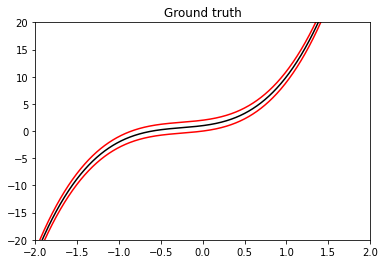

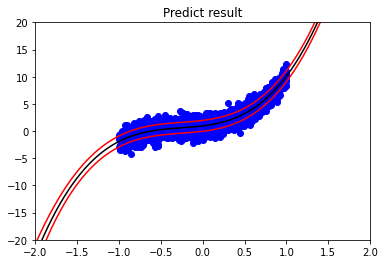

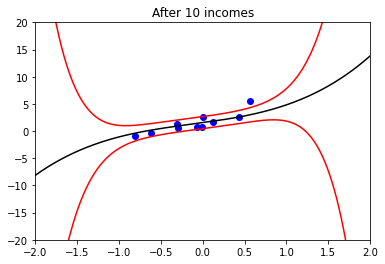

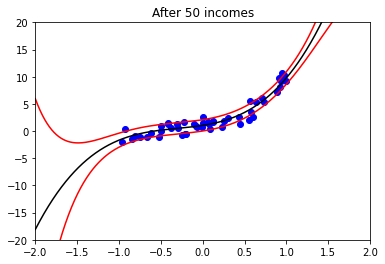

In [36]:
x = np.linspace(-2, 2, 1000)  # x座標
plot(0,             x, w.reshape((n, 1)),  np.zeros((n,n)),  'Ground truth',      plot_x, plot_y, n)  # Ground truth 就是:var matrix是零，a*1 + b*x + c*x^2 + d*x^3的abcd就是真值
plot(converge_times,x, plot_mean[2],       plot_variance[2], 'Predict result',    plot_x, plot_y, n)
plot(10,            x, plot_mean[0],       plot_variance[0], 'After 10 incomes',  plot_x, plot_y, n)
plot(50,            x, plot_mean[1],       plot_variance[1], 'After 50 incomes',  plot_x, plot_y, n)